In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [16]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            
            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [17]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [18]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [11]:
import pandas as pd

# Đọc file CSV
file_path = "DT_HPO.csv"
df = pd.read_csv(file_path)

# Nhóm dữ liệu theo 'Attack' và tìm giá trị F1 cao nhất trong từng nhóm
grouped = df.groupby('Attack', group_keys=False).apply(lambda x: x[x['F1'] == x['F1'].max()])

# Sau khi đã lọc theo F1 cao nhất, áp dụng các điều kiện bổ sung:
# 1. Chọn tham số có max_depth nhỏ nhất
# 2. Chọn tham số có min_samples_split lớn nhất
# 3. Chọn tham số có max_features lớn nhất

# Sắp xếp dữ liệu theo các điều kiện
sorted_params = grouped.sort_values(by=['Attack', 'max_depth', 'min_samples_split', 'max_features'], 
                                    ascending=[True, True, False, False])

# Lọc tham số có F1 cao nhất và chọn đầu tiên sau khi sắp xếp
extracted_params = sorted_params[['criterion', 'max_depth', 'max_features', 'min_samples_split', 'F1', 'Attack']]

# Lưu kết quả vào file CSV mới
output_path = "selected_params_per_attack.csv"
extracted_params.to_csv(output_path, index=False)

# Hiển thị kết quả
print(extracted_params)


    criterion  max_depth  max_features  min_samples_split        F1 Attack
105   entropy          1            11                  2  0.496701    ACK
141   entropy          1             8                  2  0.496701    ACK
136      gini          2            15                  8  0.496701    ACK
111   entropy          2            10                  4  0.496701    ACK
134      gini          2             9                  2  0.496701    ACK
..        ...        ...           ...                ...       ...    ...
265      gini         31            12                  7  1.000000     SP
273      gini         31            18                  5  1.000000     SP
263      gini         31            23                  4  1.000000     SP
32       gini         24            20                  8  0.994223    SYN
198      gini          4             1                  2  0.050628    UDP

[104 rows x 6 columns]


C:\Users\Admin\AppData\Local\Temp\ipykernel_12928\2812166710.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Attack', group_keys=False).apply(lambda x: x[x['F1'] == x['F1'].max()])


In [12]:
import pandas as pd

# Đọc file CSV
file_path = "LR_HPO.csv"
df = pd.read_csv(file_path)

# Nhóm dữ liệu theo 'Attack' và tìm giá trị F1 cao nhất trong từng nhóm
grouped = df.groupby('Attack', group_keys=False).apply(lambda x: x[x['F1'] == x['F1'].max()])

# Sau khi đã lọc theo F1 cao nhất, áp dụng các điều kiện bổ sung:
# 1. Chọn tham số có C nhỏ nhất
# 2. Chọn tham số có penalty là "l2"
# 3. Chọn tham số có solver là "newton-cg"

# Sắp xếp dữ liệu theo các điều kiện
sorted_params = grouped.sort_values(by=['Attack', 'C', 'penalty', 'Solver'], 
                                    ascending=[True, True, True, True])

# Lọc tham số cho mỗi Attack
extracted_params = sorted_params[['C', 'penalty', 'Solver', 'F1', 'Std', 'Time', 'No', 'Attack']]

# Lưu kết quả vào file CSV mới
output_path = "selected_params_based_on_conditions_for_attack.csv"
extracted_params.to_csv(output_path, index=False)

# Hiển thị kết quả
print(extracted_params)


            C penalty     Solver        F1           Std    Time  No Attack
27   0.000022      l2  newton-cg  0.496701  0.000000e+00  14.050   7    ACK
24   0.000924      l2  newton-cg  0.496701  0.000000e+00   9.344   4    ACK
23   0.009536      l2  newton-cg  0.496701  0.000000e+00   9.860   3    ACK
20   0.045804      l2  liblinear  0.496701  0.000000e+00   2.137   0    ACK
26   0.088059      l2  liblinear  0.496701  0.000000e+00   0.372   6    ACK
21   0.127571      l2  newton-cg  0.496701  0.000000e+00   8.553   1    ACK
29   0.206971      l2  liblinear  0.496701  0.000000e+00   1.918   9    ACK
28   1.575351      l2  liblinear  0.496701  0.000000e+00   1.194   8    ACK
22   7.764693      l2  liblinear  0.496701  0.000000e+00   1.195   2    ACK
25  22.890019      l2      lbfgs  0.496701  0.000000e+00   3.757   5    ACK
45   0.017759      l2  liblinear  0.943840  0.000000e+00   3.041   5    ARP
63   0.179617      l2      lbfgs  0.316221  0.000000e+00   5.680   3     BF
17   0.00668

C:\Users\Admin\AppData\Local\Temp\ipykernel_12928\1068020065.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Attack', group_keys=False).apply(lambda x: x[x['F1'] == x['F1'].max()])


In [19]:
ml_list={
"LR":{"SYN":LogisticRegression(C=39.7795,penalty="l2",solver="newton-cg" ),
"HTTP":LogisticRegression(C=0.0066 ,penalty="l2",solver="newton-cg" ),
"ACK":LogisticRegression(C=2.24988 ,penalty="l2",solver="newton-cg" ),    
"UDP":LogisticRegression(C=7.06252,penalty="l2",solver="liblinear" ),    
"ARP":LogisticRegression(C=0.01775 ,penalty="l2",solver="liblinear" ),
"SP":LogisticRegression(C=17.32539 ,penalty="l2",solver="liblinear" ),    
"BF":LogisticRegression(C=0.179616 ,penalty="l2",solver="lbfgs" ),    
"OS":LogisticRegression(C= 0.017423,penalty="l2",solver="newton-cg" ),
"SCHD":LogisticRegression(C=0.03319,penalty="l2",solver="newton-cg" ),    
"MHDis":LogisticRegression(C=0.57066,penalty="l2",solver="lbfgs" )},   

"DT":{"SYN":DecisionTreeClassifier(criterion="gini",max_depth=24,max_features=20,min_samples_split=8 ),
"HTTP":DecisionTreeClassifier(criterion="entropy",max_depth=1,max_features=11,min_samples_split=2 ),                      
"ACK":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=4,min_samples_split=4),            
"UDP":DecisionTreeClassifier(criterion="gini",max_depth=4,max_features=1,min_samples_split=2 ),            
"ARP":DecisionTreeClassifier(criterion="gini",max_depth=32,max_features=31,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="gini",max_depth=2,max_features=27,min_samples_split=7 ),            
"BF":DecisionTreeClassifier(criterion="gini",max_depth=20,max_features=7,min_samples_split=7 ),              
"OS":DecisionTreeClassifier(criterion="gini",max_depth=9,max_features=31,min_samples_split=5 ),            
"SCHD":DecisionTreeClassifier(criterion="gini",max_depth=8,max_features=17,min_samples_split=7 ),             
"MHDis":DecisionTreeClassifier(criterion="entropy",max_depth=19,max_features=29,min_samples_split=2 )},
}

In [20]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [21]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")

## Calculation of evaluations

In [22]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [23]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)

                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             

In [24]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  

            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)

            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             

# GA output

In [26]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [27]:
file_list={
'../csvs\\dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
'../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv':"UDP",
'../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SP",
'../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF",
'../csvs\\scan-portos-3-dec.pcap_Flow.csv':"OS",  
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SCHD",
'../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv':"MHDis"}

../csvs\dos-synflooding-1-dec.pcap_Flow.csv
['Src Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Std', 'SYN Flag Cnt', 'PSH Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.999    0.9     0.9    0.9    0.9    0.8    0.9      6.421     0.001
 1  SYN           0    2     0  LR    0.999    0.875   1  

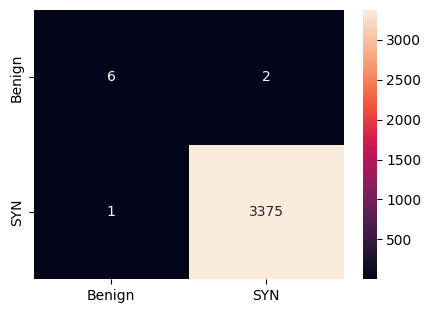





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    0.999    0.909    1     0.909  0.95   0.9    0.909    0.059     0.001
 1  SYN           0    2     0  DT    1        1        1     1      1      1      1        0.033     0.001
 2  SYN           0    3     0  DT    1        1        1     1      1      1      1        0.061     0
 3  SYN           0    4     0  DT    1        1        1     1      1      1      1        0.043     0
 4  SYN           0    5     0  DT    1        1        1     1      1      1      1        0.056     0.001
 5  SYN           0    1     1  DT    1        1        1     1      1      1      1        0.046     0.001
 6  SYN           0    2     1  DT    1        1        0.95  1      0.974  0.947  1        0.073     0.002
 7  SYN           0    3     1  

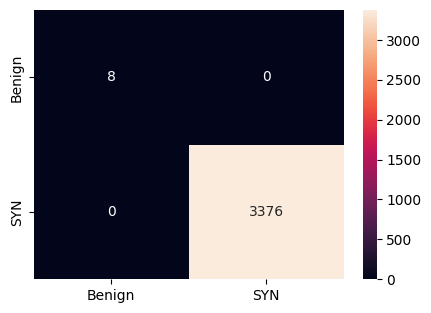





../csvs\mirai-httpflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Flow Duration', 'Flow Pkts/s', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Min', 'Fwd Pkts/s', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.44     0.531   0.594  0.531  0.383  0.051  0.531    0.501     0
 1  HTTP          0    2     0  LR    0.462    0.561   0.636  0.561  0.424  0.096  0.561    0.443     0.001
 2  HTTP          0    3     0  LR    0.932    0.923   0.93   0.923  0.926  0.853  0.923    0.541     0
 3  HTTP          0    4     0  LR    0.924    0.914   0.932  0.914  0.921  0.842  0.914    0.419     0
 4  HTTP          0    5     0  LR    0.815    0.83    0.818  0.83   0.814  0.632  0.83     0.426     0.001
 5  HTTP          0    1     1  LR    0.943    0.929   0.95

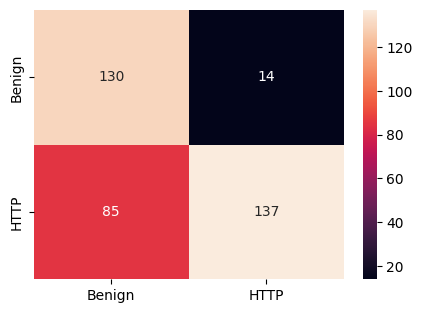





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.921    0.894   0.944  0.894  0.911  0.824  0.894    0.005     0
 1  HTTP          0    2     0  DT    0.921    0.908   0.94   0.908  0.917  0.835  0.908    0.004     0
 2  HTTP          0    3     0  DT    0.918    0.893   0.942  0.893  0.909  0.82   0.893    0.004     0.001
 3  HTTP          0    4     0  DT    0.921    0.897   0.943  0.897  0.913  0.827  0.897    0.005     0
 4  HTTP          0    5     0  DT    0.938    0.922   0.953  0.922  0.933  0.866  0.922    0.004     0.001
 5  HTTP          0    1     1  DT    0.932    0.914   0.95   0.914  0.926  0.853  0.914    0.003     0
 6  HTTP          0    2     1  DT    0.913    0.895   0.935  0.895  0.907  0.815  0.895    0.003     0
 7  HTTP          0    3     1  DT    0.932 

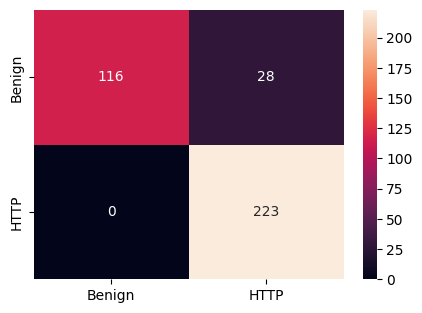





../csvs\mirai-ackflooding-4-dec.pcap_Flow.csv
['TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.886    0.904   0.887  0.904  0.885  0.773  0.904    0.409     0.001
 1  ACK           0    2     0  LR    0.841    0.871   0.853  0.871  0.84   0.688  0.871    0.486     0
 2  ACK           0    3     0  LR    0.865    0.88    0.875  0.88   0.865  0.734  0.88     0.437     0
 3  ACK           0    4     0

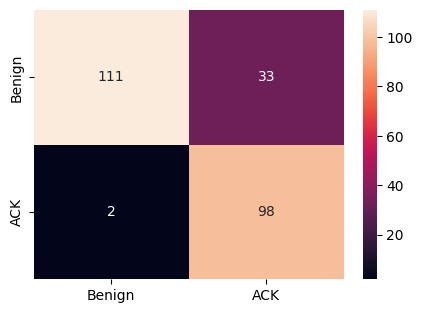





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.837    0.869   0.85   0.869  0.836  0.681  0.869    0.003     0.001
 1  ACK           0    2     0  DT    0.878    0.902   0.877  0.902  0.876  0.755  0.902    0.107     0
 2  ACK           0    3     0  DT    0.861    0.883   0.868  0.883  0.86   0.725  0.883    0.002     0.001
 3  ACK           0    4     0  DT    0.869    0.881   0.888  0.881  0.869  0.743  0.881    0.003     0
 4  ACK           0    5     0  DT    0.902    0.911   0.91   0.911  0.902  0.806  0.911    0.003     0.001
 5  ACK           0    1     1  DT    0.874    0.909   0.855  0.909  0.865  0.735  0.909    0.029     0
 6  ACK           0    2     1  DT    0.906    0.916   0.912  0.916  0.906  0.814  0.916    0.003     0
 7  ACK           0    3     1  DT    0.

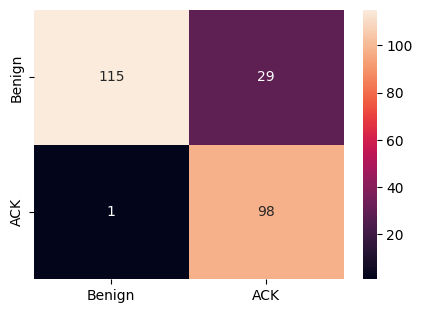





../csvs\mirai-udpflooding-4-dec.pcap_Flow.csv
['Src Port', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    0.96       0.5   0.48     0.5  0.49       0    0.5    0.002     0
 1  UDP           0    2     0  LR    0.98       0.5   0.49     0.5  0.495      0    0.5    0.003     0
 2  UDP           0    3     0  LR    0.966      0.5   0.483    0.5  0.491      0    0.5    0.002     0.001
 3  UDP           0    4     0  LR    0.973      0.5   0.486    0.5  0.493      0    0.5    0.003     0
 4  UDP           0    5     0  LR    0.986      0.5   0.493    0.5  0.497      0    0.5    0.002     0
 5  UDP           0    1     1  LR    0.98       0.5   0.49     0.5  0.495      0    0.5    0.002     0
 6  UDP           0    2     1  LR    0.973      0.5   0.487    0.5  

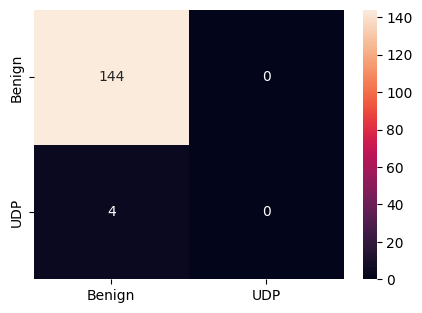





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    0.993    0.833   0.997  0.833  0.898  0.797  0.833    0.001     0.001
 1  UDP           0    2     0  DT    0.987    0.5     0.493  0.5    0.497  0      0.5      0.001     0.001
 2  UDP           0    3     0  DT    0.986    0.986   0.5    0.493  0.497  0      0        0.001     0.001
 3  UDP           0    4     0  DT    0.953    0.708   0.976  0.708  0.782  0.568  0.708    0.003     0
 4  UDP           0    5     0  DT    0.986    0.667   0.993  0.667  0.747  0.495  0.667    0.002     0
 5  UDP           0    1     1  DT    0.98     0.75    0.99   0.75   0.828  0.657  0.75     0.002     0
 6  UDP           0    2     1  DT    0.966    0.688   0.983  0.688  0.764  0.532  0.688    0.001     0
 7  UDP           0    3     1  DT    0.

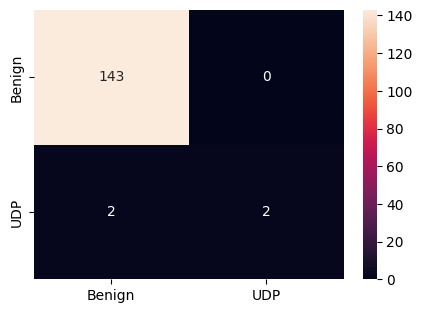





../csvs\mitm-arpspoofing-6-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Std', 'Pkt Len Var', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Idle Mean', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.971    0.972   0.97   0.97

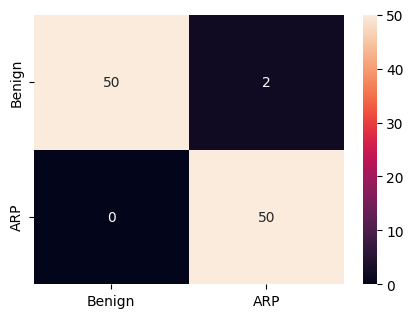





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.981    0.98    0.982  0.98   0.981  0.961  0.98     0.006     0
 1  ARP           0    2     0  DT    1        1       1      1      1      1      1        0.056     0.002
 2  ARP           0    3     0  DT    0.971    0.972   0.971  0.972  0.971  0.942  0.972    0.005     0.001
 3  ARP           0    4     0  DT    1        1       1      1      1      1      1        0.034     0
 4  ARP           0    5     0  DT    0.981    0.981   0.981  0.981  0.981  0.961  0.981    0.005     0.013
 5  ARP           0    1     1  DT    1        1       1      1      1      1      1        0.007     0
 6  ARP           0    2     1  DT    0.981    0.982   0.98   0.982  0.981  0.961  0.982    0.005     0
 7  ARP           0    3     1  DT    0.

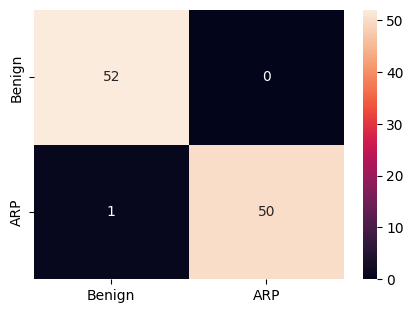





../csvs\scan-hostport-3-dec.pcap_Flow.csv
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Header Len', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.971    0.879   0.813  0.879  0.842  0.685  0.879    0.372     0.001
 1  SCHD          0    2     0  LR    0.995   

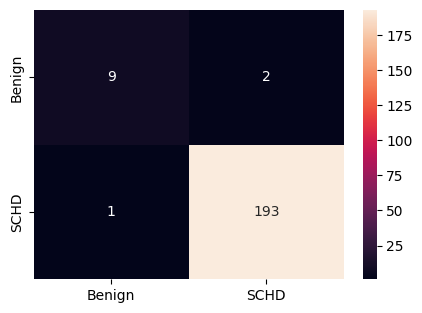





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT        1        1       1      1     1      1      1    0.001     0
 1  SCHD          0    2     0  DT        1        1       1      1     1      1      1    0.002     0.001
 2  SCHD          0    3     0  DT        1        1       1      1     1      1      1    0.002     0
 3  SCHD          0    4     0  DT        1        1       1      1     1      1      1    0.002     0.001
 4  SCHD          0    5     0  DT        1        1       1      1     1      1      1    0.003     0.001
 5  SCHD          0    1     1  DT        1        1       1      1     1      1      1    0.002     0
 6  SCHD          0    2     1  DT        1        1       1      1     1      1      1    0.002     0
 7  SCHD          0    3     1  DT        1      

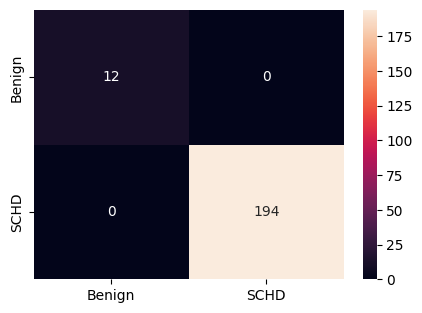





../csvs\mirai-hostbruteforce-5-dec.pcap_Flow.csv
['TotLen Fwd Pkts', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.848    0.5     0.424  0.5    0.459   0     0.5      0.031     0
 1  BF            0    2     0  LR    0.817    0.5     0.409  0.5    0.45    0     0.5      0.025     0
 2  BF            0    3     0  LR    0.858    0.497   0.431  0.497  0.462  -0.01  0.497    0.039     0
 3  BF            0    4     0  LR    0.838    0.5     0.419  0.5    0.456   0     0.5      0.044     0.001
 4  BF            0    5     0  LR    0.878    0.5     0.439  0.5    0.467   0     0.5      0.023     0
 5  BF            0    1     1  LR    0.888    0.5     0.444  0.5    

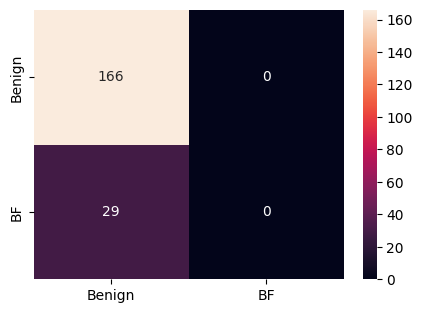





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.914    0.771   0.826  0.771  0.795  0.59   0.771    0.006     0
 1  BF            0    2     0  DT    0.924    0.816   0.849  0.816  0.831  0.662  0.816    0.008     0
 2  BF            0    3     0  DT    0.939    0.923   0.866  0.923  0.891  0.782  0.923    0.007     0.001
 3  BF            0    4     0  DT    0.888    0.757   0.805  0.757  0.778  0.556  0.757    0.006     0.001
 4  BF            0    5     0  DT    0.883    0.778   0.799  0.778  0.788  0.576  0.778    0.007     0.001
 5  BF            0    1     1  DT    0.878    0.757   0.757  0.757  0.757  0.515  0.757    0.008     0.001
 6  BF            0    2     1  DT    0.914    0.818   0.845  0.818  0.831  0.661  0.818    0.006     0
 7  BF            0    3     1  DT  

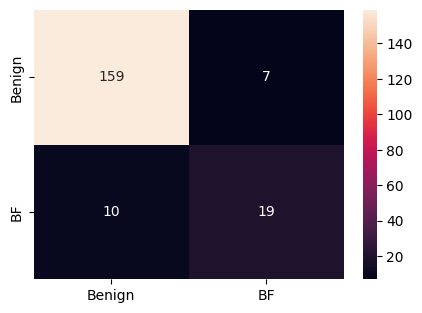





../csvs\scan-portos-3-dec.pcap_Flow.csv
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Std', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  LR    0.955    0.859   0.941  0.859  0.894  0.788  0.8

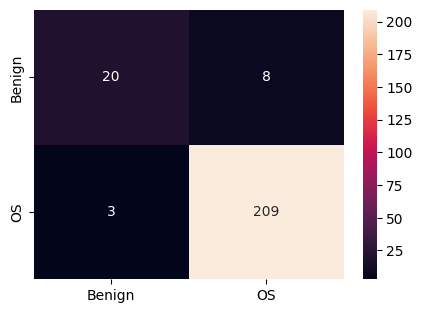





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.996    0.998   0.981  0.998  0.989  0.979  0.998    0.006     0.001
 1  OS            0    2     0  DT    0.988    0.978   0.964  0.978  0.971  0.942  0.978    0.008     0.001
 2  OS            0    3     0  DT    0.979    0.974   0.939  0.974  0.956  0.911  0.974    0.01      0
 3  OS            0    4     0  DT    0.992    0.995   0.964  0.995  0.979  0.958  0.995    0.005     0.001
 4  OS            0    5     0  DT    0.979    0.931   0.972  0.931  0.95   0.901  0.931    0.005     0
 5  OS            0    1     1  DT    0.963    0.889   0.948  0.889  0.916  0.831  0.889    0.005     0.001
 6  OS            0    2     1  DT    0.996    0.998   0.985  0.998  0.991  0.982  0.998    0.007     0.001
 7  OS            0    3     1  

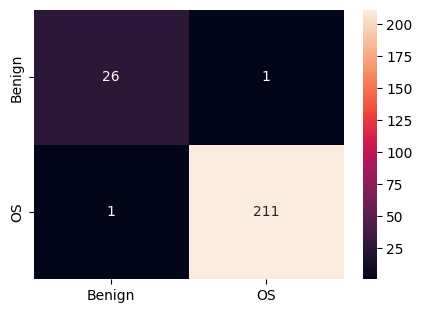





../csvs\mirai-hostbruteforce-3-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  MHDis         0    1     0  LR    0.864    0.528   0.767  0.528  0.519   0.09   0.528    0.065     0
 1  MHDis         0    2     0  LR    0.877    0.545   0.741  0.545  0.552   0.

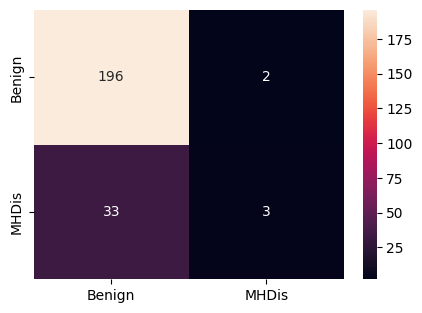





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT    0.996    0.986   0.998  0.986  0.992  0.983  0.986    0.016     0.001
 1  MHDis         0    2     0  DT    0.991    0.982   0.982  0.982  0.982  0.965  0.982    0.015     0
 2  MHDis         0    3     0  DT    0.996    0.986   0.997  0.986  0.992  0.984  0.986    0.014     0
 3  MHDis         0    4     0  DT    0.987    0.981   0.971  0.981  0.976  0.952  0.981    0.014     0.001
 4  MHDis         0    5     0  DT    0.996    0.986   0.997  0.986  0.992  0.984  0.986    0.042     0
 5  MHDis         0    1     1  DT    0.987    0.961   0.992  0.961  0.976  0.951  0.961    0.051     0
 6  MHDis         0    2     1  DT    0.996    0.998   0.986  0.998  0.992  0.983  0.998    0.013     0.001
 7  MHDis         0    3     1  DT    0.

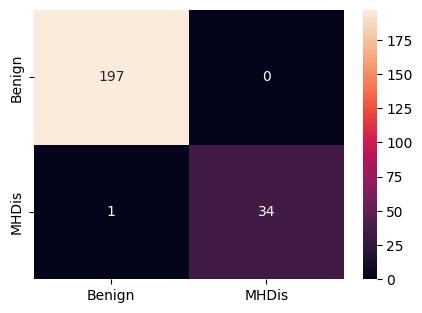

In [28]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   

# SS

In [29]:
file_list_session={
"SYN":[ '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-2-dec.pcap_Flow.csv',],
"HTTP":['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-httpflooding-1-dec.pcap_Flow.csv'],
"ACK":['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv'],
"UDP":[ '../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-udpflooding-1-dec.pcap_Flow.csv'],
"ARP":[ '../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-4-dec.pcap_Flow.csv'],
"SP":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"BF":[ '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
"OS":['../csvs\\scan-portos-3-dec.pcap_Flow.csv','../csvs\\scan-portos-6-dec.pcap_Flow.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-2-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Std', 'SYN Flag Cnt', 'PSH Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.996    0.867   0.845  0.867  0.855  0.711  0.867    6.457     0.003
 1  SYN           0    1     1  LR    0.996    0.867   0.845  0.867  0.855  0.711  0.867    4.508 

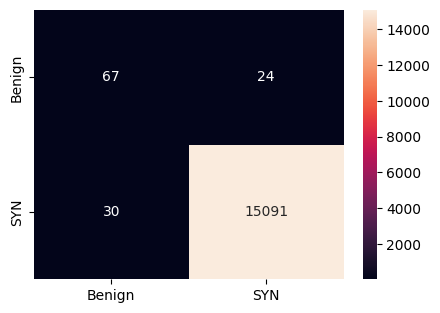





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    0.999    0.967   0.988  0.967  0.977  0.955  0.967    0.075     0.012
 1  SYN           0    1     1  DT    1        0.989   1      0.989  0.994  0.989  0.989    0.149     0.005
 2  SYN           0    1     2  DT    1        0.994   0.989  0.994  0.992  0.984  0.994    0.094     0.005
 3  SYN           0    1     3  DT    1        0.989   1      0.989  0.994  0.989  0.989    0.052     0.012
 4  SYN           0    1     4  DT    1        0.994   0.989  0.994  0.992  0.984  0.994    0.062     0.004
 5  SYN           0    1     5  DT    1        0.994   0.989  0.994  0.992  0.984  0.994    0.043     0.011
 6  SYN           0    1     6  DT    0.999    0.967   0.988  0.967  0.977  0.955  0.967    0.046     0.004
 7  SYN           0    1

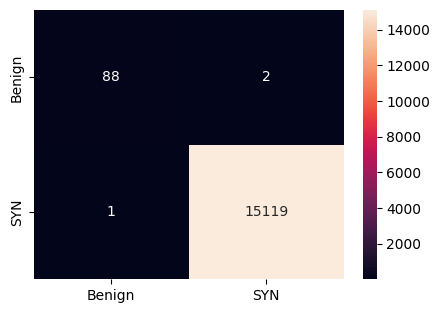





HTTP
['Dst Port', 'Flow Duration', 'Flow Pkts/s', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Min', 'Fwd Pkts/s', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR     0.92    0.908   0.938  0.908  0.916  0.833  0.908    0.456     0
 1  HTTP          0    1     1  LR     0.92    0.908   0.938  0.908  0.916  0.833  0.908    0.496     0.001
 2  HTTP          0    1     2  LR     0.92    0.908   0.938  0.908  0.916  0.833  0.908    0.575     0
 3  HTTP          0    1     3  LR     0.92    0.908   0.938  0.908  0.916  0.833  0.908    0.559     0
 4  HTTP          0    1     4  LR     0.92    0.908   0.938  0.908  0.916  0.833  0.908    0.453     0.001
 5  HTTP          0    1     5  LR     0.92    0.908   0.938  0.908  0.916  0.833  0.908    0.443    

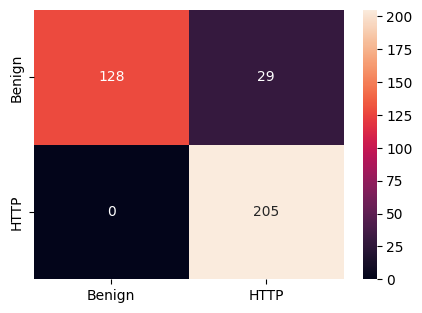





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.009     0.001
 1  HTTP          0    1     1  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.003     0.001
 2  HTTP          0    1     2  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.005     0.001
 3  HTTP          0    1     3  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.006     0
 4  HTTP          0    1     4  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.005     0
 5  HTTP          0    1     5  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.006     0
 6  HTTP          0    1     6  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.007     0
 7  HTTP          0    1     7  DT    0.

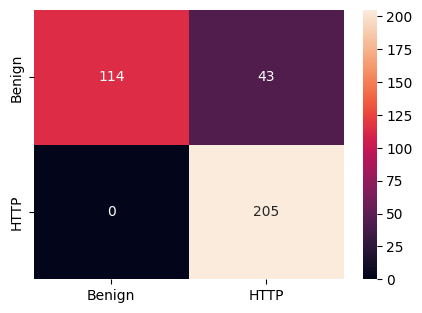





ACK
['TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.452    0.627   0.511  0.627  0.337   0.02  0.627    0.525     0.001
 1  ACK           0    1     1  LR    0.452    0.627   0.511  0.627  0.337   0.02  0.627    0.646     0.001
 2  ACK           0    1     2  LR    0.452    0.627   0.511  0.627  0.337   0.02  0.627    0.446     0
 3  ACK           0    1     3  LR    0.452    0.627   0.511  0.627 

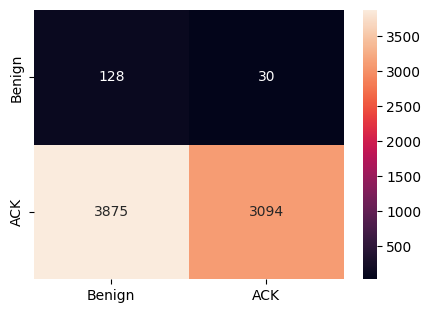





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.993    0.848   0.992  0.848  0.907  0.814  0.848    0.003     0.001
 1  ACK           0    1     1  DT    0.997    0.933   0.995  0.933  0.962  0.924  0.933    0.003     0.002
 2  ACK           0    1     2  DT    0.991    0.878   0.9    0.878  0.888  0.777  0.878    0.002     0.002
 3  ACK           0    1     3  DT    0.991    0.878   0.9    0.878  0.888  0.777  0.878    0.007     0.002
 4  ACK           0    1     4  DT    0.997    0.937   0.995  0.937  0.964  0.928  0.937    0.002     0.001
 5  ACK           0    1     5  DT    0.997    0.937   0.995  0.937  0.964  0.928  0.937    0.005     0.001
 6  ACK           0    1     6  DT    0.997    0.937   0.995  0.937  0.964  0.928  0.937    0.002     0.002
 7  ACK           0    1

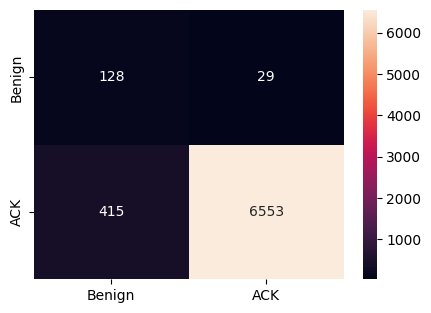





UDP
['Src Port', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.003     0.001
 1  UDP           0    1     1  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.005     0.001
 2  UDP           0    1     2  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.004     0
 3  UDP           0    1     3  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.002     0.001
 4  UDP           0    1     4  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.012     0
 5  UDP           0    1     5  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.004     0.001
 6  UDP           0    1     6  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.002  

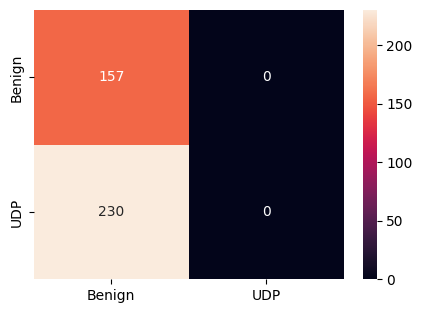





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    0.532    0.607   0.732  0.607  0.493  0.18   0.607    0.004     0.001
 1  UDP           0    1     1  DT    0.693    0.739   0.776  0.739  0.689  0.429  0.739    0.008     0
 2  UDP           0    1     2  DT    0.532    0.607   0.732  0.607  0.493  0.18   0.607    0.002     0
 3  UDP           0    1     3  DT    0.419    0.511   0.705  0.511  0.313  0.018  0.511    0.002     0.001
 4  UDP           0    1     4  DT    0.946    0.953   0.941  0.953  0.945  0.89   0.953    0.001     0.001
 5  UDP           0    1     5  DT    0.649    0.702   0.758  0.702  0.64   0.357  0.702    0.003     0.001
 6  UDP           0    1     6  DT    0.419    0.511   0.705  0.511  0.313  0.018  0.511    0.002     0
 7  UDP           0    1     7  DT  

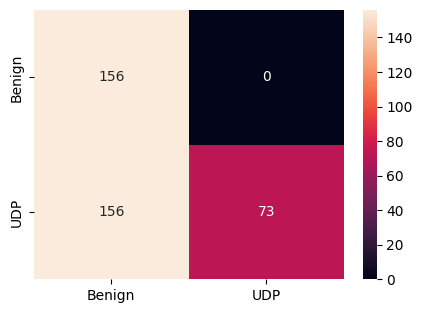





ARP
['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Std', 'Pkt Len Var', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Idle Mean', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.935    0.913    0.94  0.913  0.925  0.849  0.913    0.065     0.001

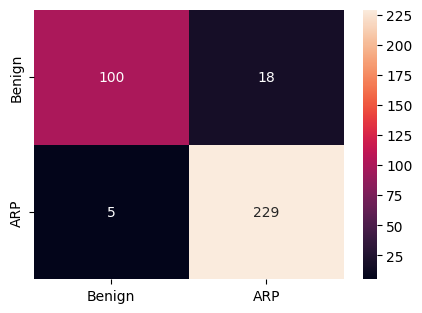





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.994    0.992   0.996  0.992  0.994  0.987  0.992    0.023     0
 1  ARP           0    1     1  DT    0.969    0.966   0.964  0.966  0.965  0.93   0.966    0.006     0.009
 2  ARP           0    1     2  DT    0.989    0.985   0.989  0.985  0.987  0.974  0.985    0.011     0.001
 3  ARP           0    1     3  DT    0.957    0.962   0.946  0.962  0.953  0.906  0.962    0.009     0.001
 4  ARP           0    1     4  DT    0.983    0.979   0.983  0.979  0.981  0.962  0.979    0.005     0
 5  ARP           0    1     5  DT    0.96     0.96    0.952  0.96   0.956  0.912  0.96     0.006     0.001
 6  ARP           0    1     6  DT    0.96     0.957   0.954  0.957  0.956  0.911  0.957    0.008     0
 7  ARP           0    1     7  DT  

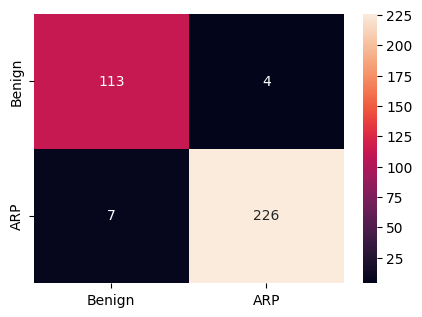





SP
['Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    0.985    0.917   0.992  0.917  0.951  0.902  0.917    0.023     0.001
 1  SP            0    1     1  LR    0.985    0.917   0.992  0.917  0.951  0.902  0.917    0.036     0
 2  SP            0    1     2  LR    0.985    0.91

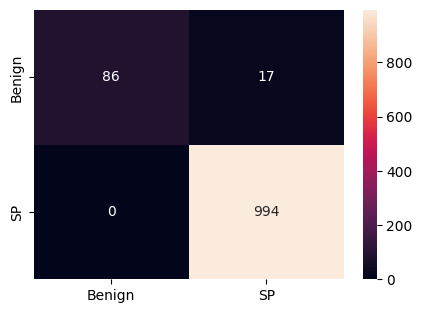





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0
 1  SP            0    1     1  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.004     0
 2  SP            0    1     2  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.004     0.002
 3  SP            0    1     3  DT    0.965    0.977   0.866  0.977  0.912  0.824  0.977    0.002     0
 4  SP            0    1     4  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0
 5  SP            0    1     5  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0.001
 6  SP            0    1     6  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0.001
 7  SP            0    1     7  DT    0.

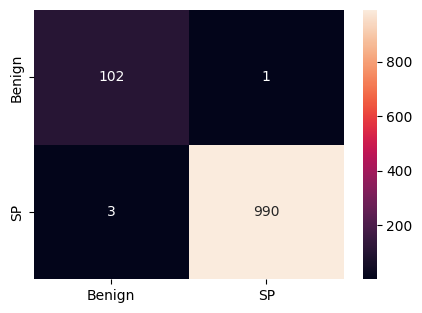





BF
['TotLen Fwd Pkts', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.844    0.501   0.523  0.501  0.463  0.003  0.501    0.043     0.001
 1  BF            0    1     1  LR    0.844    0.501   0.523  0.501  0.463  0.003  0.501    0.073     0.001
 2  BF            0    1     2  LR    0.844    0.501   0.523  0.501  0.463  0.003  0.501    0.086     0.001
 3  BF            0    1     3  LR    0.844    0.501   0.523  0.501  0.463  0.003  0.501    0.086     0.001
 4  BF            0    1     4  LR    0.844    0.501   0.523  0.501  0.463  0.003  0.501    0.086     0.001
 5  BF            0    1     5  LR    0.844    0.501   0.523  0.501  0.463  0.003  0.501    0.046  

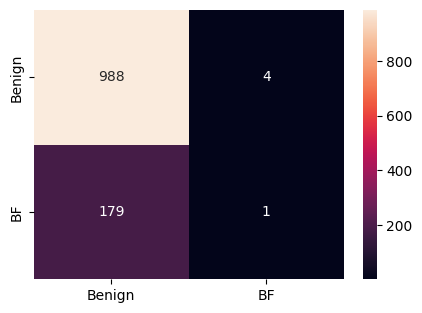





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.868    0.704   0.747  0.704  0.722  0.445  0.704    0.015     0.001
 1  BF            0    1     1  DT    0.878    0.712   0.774  0.712  0.736  0.475  0.712    0.017     0.012
 2  BF            0    1     2  DT    0.877    0.711   0.771  0.711  0.735  0.472  0.711    0.026     0.001
 3  BF            0    1     3  DT    0.881    0.712   0.785  0.712  0.739  0.481  0.712    0.009     0.001
 4  BF            0    1     4  DT    0.878    0.71    0.775  0.71   0.735  0.472  0.71     0.023     0.001
 5  BF            0    1     5  DT    0.88     0.715   0.778  0.715  0.74   0.482  0.715    0.011     0.001
 6  BF            0    1     6  DT    0.883    0.715   0.789  0.715  0.743  0.489  0.715    0.008     0.001
 7  BF            0    1

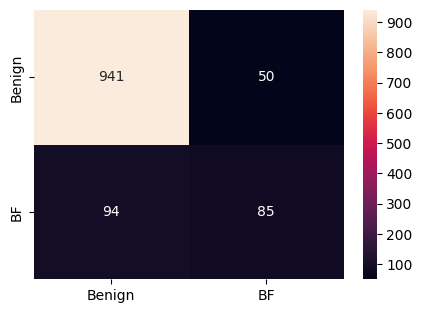





OS
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Std', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  LR    0.988    0.841   0.945  0.841  0.886  0.772  0.841    1.246     0.001
 1  OS         

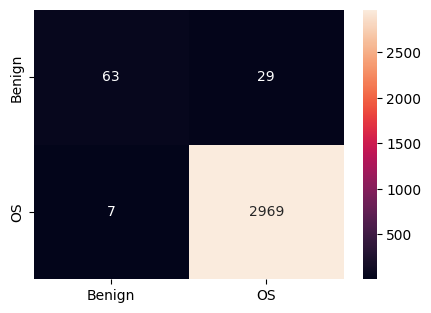





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.992    0.88    0.969  0.88   0.92   0.839  0.88     0.011     0.001
 1  OS            0    1     1  DT    0.995    0.987   0.941  0.987  0.963  0.925  0.987    0.015     0.001
 2  OS            0    1     2  DT    0.991    0.89    0.952  0.89   0.919  0.838  0.89     0.01      0.001
 3  OS            0    1     3  DT    0.992    0.88    0.969  0.88   0.92   0.839  0.88     0.008     0.001
 4  OS            0    1     4  DT    0.994    0.96    0.937  0.96   0.948  0.896  0.96     0.008     0
 5  OS            0    1     5  DT    0.993    0.954   0.932  0.954  0.943  0.885  0.954    0.015     0.001
 6  OS            0    1     6  DT    0.993    0.949   0.935  0.949  0.942  0.884  0.949    0.013     0.001
 7  OS            0    1    

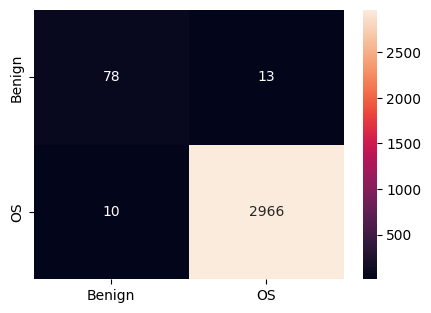





SCHD
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Header Len', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.967    0.891   0.912  0.891  0.901  0.802  0.891    0.611     0.002
 1  SCHD          0    1     1  LR    0.967    0.891   0.912  0.891  0.901  0.802  

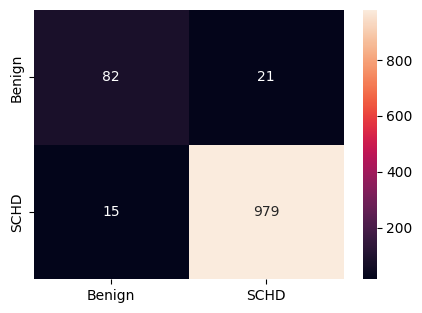





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0
 1  SCHD          0    1     1  DT    0.994    0.996   0.968  0.996  0.982  0.964  0.996    0.005     0.001
 2  SCHD          0    1     2  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0
 3  SCHD          0    1     3  DT    0.965    0.977   0.866  0.977  0.912  0.824  0.977    0.004     0.02
 4  SCHD          0    1     4  DT    0.994    0.996   0.968  0.996  0.982  0.964  0.996    0.004     0.001
 5  SCHD          0    1     5  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.004     0.002
 6  SCHD          0    1     6  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0.001
 7  SCHD          0    1     7  D

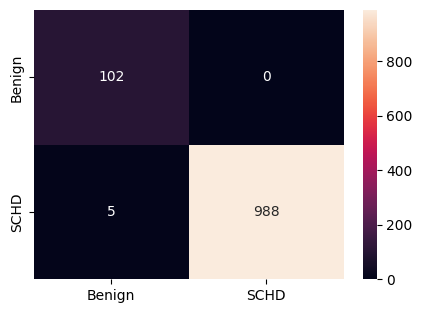





MHDis
['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  MHDis         0    1     0  LR    0.785    0.492   0.425  0.492  0.444  -0.024  0.492    0.136     0.001
 1  MHDis         0    1     1  LR    0.785    0.492   0.425  0.492  0.444  -0.024  0.492    0.125     0
 2  MHDis    

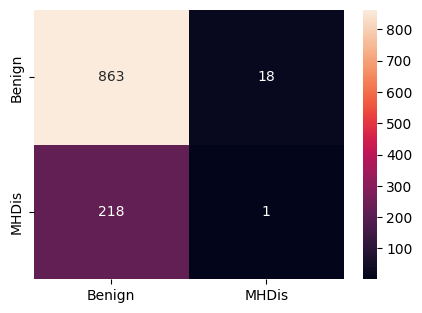





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  MHDis         0    1     0  DT    0.692    0.432   0.388  0.432  0.409  -0.164  0.432    0.017     0
 1  MHDis         0    1     1  DT    0.692    0.432   0.388  0.432  0.409  -0.164  0.432    0.011     0.001
 2  MHDis         0    1     2  DT    0.694    0.433   0.388  0.433  0.41   -0.162  0.433    0.024     0.001
 3  MHDis         0    1     3  DT    0.691    0.431   0.388  0.431  0.409  -0.165  0.431    0.011     0.001
 4  MHDis         0    1     4  DT    0.692    0.432   0.388  0.432  0.409  -0.164  0.432    0.026     0.001
 5  MHDis         0    1     5  DT    0.692    0.432   0.388  0.432  0.409  -0.164  0.432    0.011     0.001
 6  MHDis         0    1     6  DT    0.694    0.433   0.388  0.433  0.41   -0.162  0.433    0.01      0.001
 7  MHDis         0

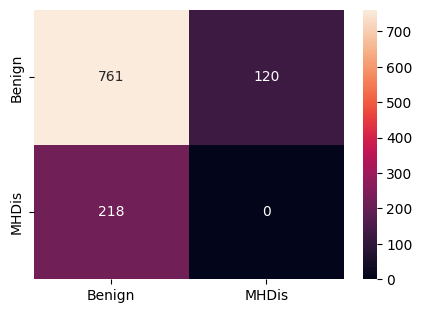

In [30]:
folder("results/val/")

for file in file_list_session:
    print(file)
    feature=feature_list[file]
    train=file_list_session[file][0]
    test=file_list_session[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   

In [ ]:
import time

# sleep for 3 seconds
print('Sleep time: ', str(3600), 'seconds')
time.sleep(3600)
print('Woke up after: ', str(3), 'seconds')


Sleep time:  3600 seconds


# TEST

In [ ]:
file_list={
'SYN': ['../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs/DDoS TCP SYN Flood Attacks-0001.pcap_Flow'],
'HTTP': ['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs/NetatmoCamHTTPFlood_1.pcap_Flow.csv'],
'ACK': ['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv', '../csvs/NetatmoCamTCPFlood_3.pcap_ACK.csv'],
'UDP': ['../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv', '../csvs/UDP_DDoS_00001.pcap_Flow.csv'],
'ARP': ['../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv',  '../csvs/ARP_MitM_FE.csv'],
'SP': ['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs/[Port_scan]Google_Home_Mini_FE.csv'],
'BF': ['../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv', '../csvs/AmcrestCamBruteForce_1.pcap_Flow.csv'],
'OS': ['../csvs\\scan-portos-3-dec.pcap_Flow.csv', '../csvs/[OS_Service_Detection]Google_Home_Mini_FE.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\scan-hostport-3-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv', '../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv' ]}

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.063     0.097
 1  SYN           1    1     1  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.049     0.067
 2  SYN           1    1     2  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.063     0.062
 3  SYN      

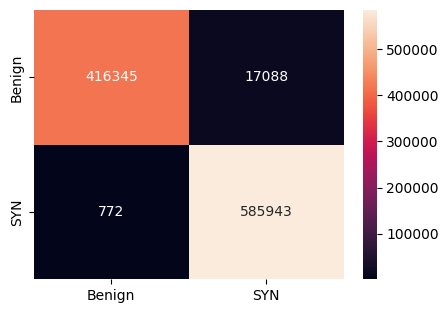





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  DT    1        1       1      1      1      1      1        0.016     0.169
 1  SYN           1    1     1  DT    0.427    0.502   0.713  0.502  0.302  0.003  0.502    0.028     0.162
 2  SYN           1    1     2  DT    1        1       1      1      1      1      1        0.016     0.204
 3  SYN           1    1     3  DT    1        1       1      1      1      1      1        0.01      0.157
 4  SYN           1    1     4  DT    1        1       1      1      1      1      1        0.016     0.196
 5  SYN           1    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0.172
 6  SYN           1    1     6  DT    1        1       1      1      1      1      1        0.016     0.204
 7  SYN           1    1

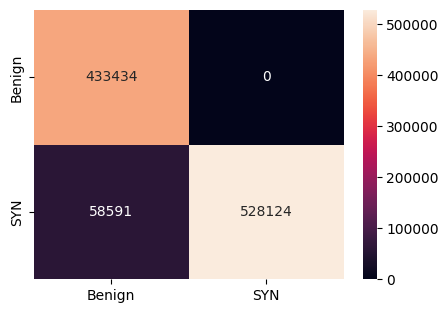





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  RF        1        1       1      1     1      1      1    1.178     8.276
 1  SYN           1    1     1  RF        1        1       1      1     1      1      1    1.255     8.426
 2  SYN           1    1     2  RF        1        1       1      1     1      1      1    1.146     8.262
 3  SYN           1    1     3  RF        1        1       1      1     1      1      1    1.091     8.281
 4  SYN           1    1     4  RF        1        1       1      1     1      1      1    1.154     8.007
 5  SYN           1    1     5  RF        1        1       1      1     1      1      1    1.178     8.361
 6  SYN           1    1     6  RF        1        1       1      1     1      1      1    1.194     8.294
 7  SYN           1    1     7  R

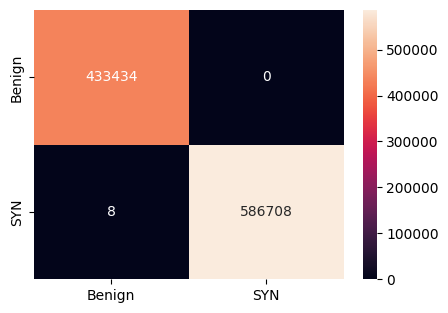





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.14     60.761
 1  SYN           1    1     1  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.103    67.732
 2  SYN           1    1     2  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.105    68.925
 3  SYN           1    1     3  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.083    67.94
 4  SYN           1    1     4  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.094    66.964
 5  SYN           1    1     5  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.107    67.073
 6  SYN           1    1     6  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.11     66.064
 7  SYN           1    1 

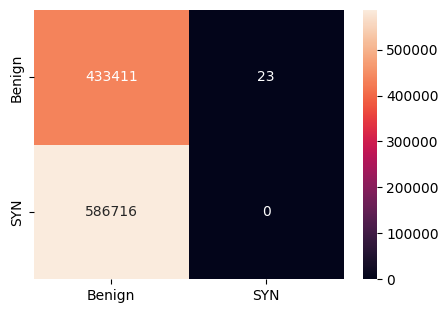





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.015     0.904
 1  SYN           1    1     1  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.768
 2  SYN           1    1     2  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.835
 3  SYN           1    1     3  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0         0.792
 4  SYN           1    1     4  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.017     0.771
 5  SYN           1    1     5  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0         0.802
 6  SYN           1    1     6  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.791
 7  SYN           1    1

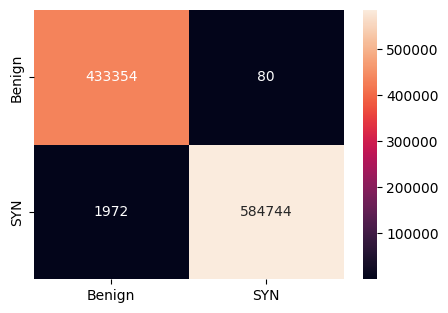





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  XGB       1        1       1      1     1      1      1    5.765     1.485
 1  SYN           1    1     1  XGB       1        1       1      1     1      1      1    5.654     1.576
 2  SYN           1    1     2  XGB       1        1       1      1     1      1      1    5.651     1.429
 3  SYN           1    1     3  XGB       1        1       1      1     1      1      1    5.804     1.499
 4  SYN           1    1     4  XGB       1        1       1      1     1      1      1    5.725     1.495
 5  SYN           1    1     5  XGB       1        1       1      1     1      1      1    5.704     1.459
 6  SYN           1    1     6  XGB       1        1       1      1     1      1      1    5.883     1.486
 7  SYN           1    1     7  X

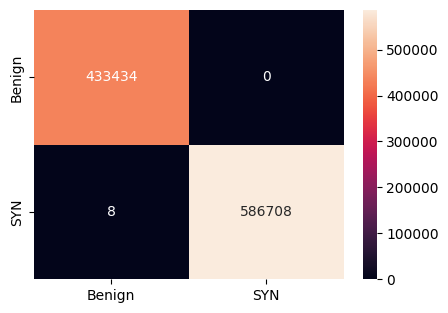





HTTP
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.355     0.016
 1  HTTP          1    1     1  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.377     0.012
 2  HTTP          1    1     2  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.372     0.016
 3  HTTP          1    1     3  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.381     0.02
 4  HTTP          1    1     4  LR     0.45      0.5   0.225    0.5  0.31   

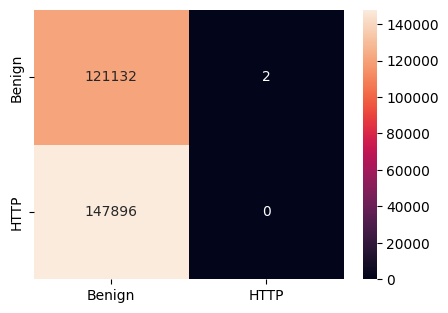





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  DT    1        1       1      1      1      1      1        0.045     0.031
 1  HTTP          1    1     1  DT    1        1       1      1      1      1      1        0.016     0.031
 2  HTTP          1    1     2  DT    1        1       1      1      1      1      1        0.016     0.031
 3  HTTP          1    1     3  DT    1        1       1      1      1      1      1        0.031     0.016
 4  HTTP          1    1     4  DT    1        1       1      1      1      1      1        0.042     0.025
 5  HTTP          1    1     5  DT    1        1       1      1      1      1      1        0.031     0.031
 6  HTTP          1    1     6  DT    1        1       1      1      1      1      1        0.047     0.031
 7  HTTP          1    1

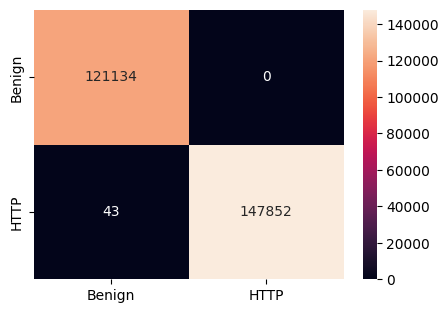





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  RF        1        1       1      1     1      1      1    1.747     1.533
 1  HTTP          1    1     1  RF        1        1       1      1     1      1      1    1.657     1.333
 2  HTTP          1    1     2  RF        1        1       1      1     1      1      1    1.872     1.564
 3  HTTP          1    1     3  RF        1        1       1      1     1      1      1    1.874     1.574
 4  HTTP          1    1     4  RF        1        1       1      1     1      1      1    1.835     1.494
 5  HTTP          1    1     5  RF        1        1       1      1     1      1      1    1.841     1.589
 6  HTTP          1    1     6  RF        1        1       1      1     1      1      1    1.794     1.541
 7  HTTP          1    1     7  R

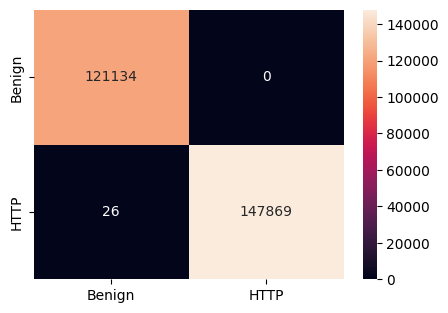





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     6.276
 1  HTTP          1    1     1  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.051     6.292
 2  HTTP          1    1     2  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.048     6.504
 3  HTTP          1    1     3  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     6.118
 4  HTTP          1    1     4  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     5.76
 5  HTTP          1    1     5  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     5.64
 6  HTTP          1    1     6  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.033     6.2
 7  HTTP          1    1    

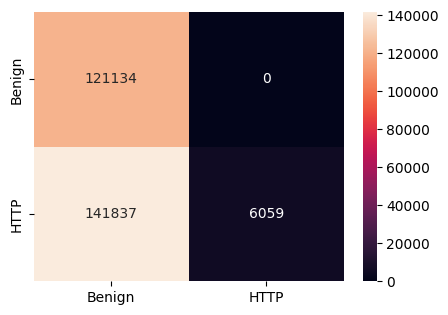





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.109
 1  HTTP          1    1     1  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.012     0.112
 2  HTTP          1    1     2  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.111
 3  HTTP          1    1     3  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.141
 4  HTTP          1    1     4  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.125
 5  HTTP          1    1     5  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0         0.125
 6  HTTP          1    1     6  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.141
 7  HTTP          1    1

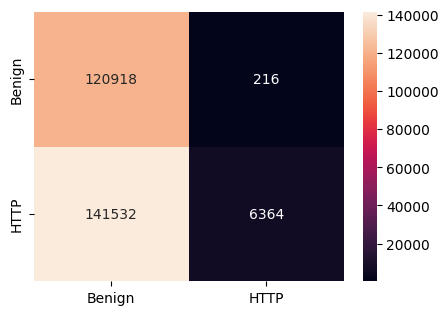





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  XGB       1        1       1      1     1      1      1    2.134     0.21
 1  HTTP          1    1     1  XGB       1        1       1      1     1      1      1    2.2       0.217
 2  HTTP          1    1     2  XGB       1        1       1      1     1      1      1    2.231     0.205
 3  HTTP          1    1     3  XGB       1        1       1      1     1      1      1    2.212     0.235
 4  HTTP          1    1     4  XGB       1        1       1      1     1      1      1    2.164     0.229
 5  HTTP          1    1     5  XGB       1        1       1      1     1      1      1    2.082     0.206
 6  HTTP          1    1     6  XGB       1        1       1      1     1      1      1    2.065     0.218
 7  HTTP          1    1     7  XG

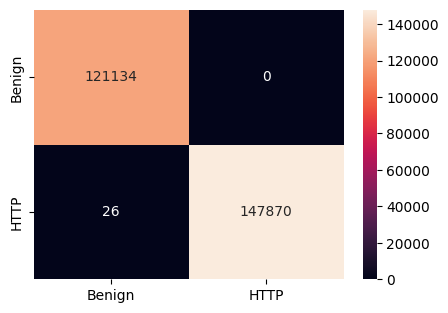





ACK
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.082     0
 1  ACK           1    1     1  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.086     0.002
 2  ACK           1    1     2  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.081     0.002
 3  ACK           1    1     3  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.082     0.001
 4  ACK           1    1     4  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.082     0
 5  ACK           1    1     5  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.085     0
 6  ACK           1    1     6  LR    0.989    0

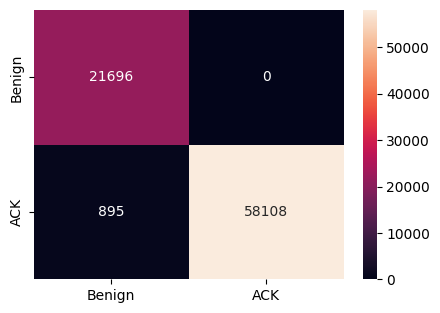





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.026     0.003
 1  ACK           1    1     1  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.012     0
 2  ACK           1    1     2  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.015     0.009
 3  ACK           1    1     3  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.02      0.004
 4  ACK           1    1     4  DT    0.997    0.998   0.995  0.998  0.997  0.993  0.998    0.011     0
 5  ACK           1    1     5  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.021     0.005
 6  ACK           1    1     6  DT    0.269    0.5     0.134  0.5    0.212  0      0.5      0.016     0.01
 7  ACK           1    1     7  D

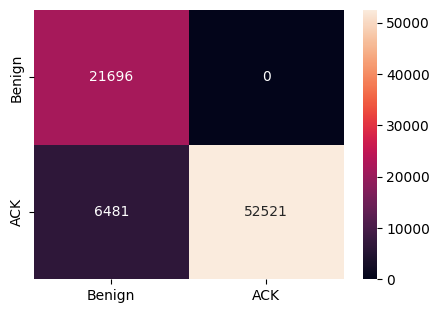





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.98      0.312
 1  ACK           1    1     1  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.948     0.279
 2  ACK           1    1     2  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.87      0.273
 3  ACK           1    1     3  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.927     0.302
 4  ACK           1    1     4  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    1.022     0.33
 5  ACK           1    1     5  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.928     0.273
 6  ACK           1    1     6  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.944     0.288
 7  ACK           1    1 

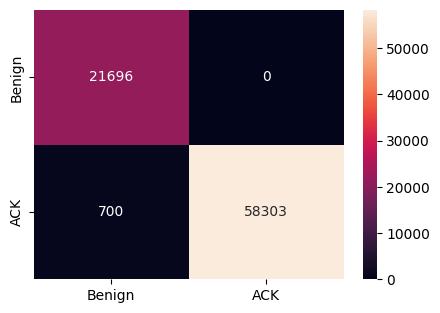





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.533
 1  ACK           1    1     1  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.569
 2  ACK           1    1     2  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.029     1.559
 3  ACK           1    1     3  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.024     1.558
 4  ACK           1    1     4  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.569
 5  ACK           1    1     5  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.564
 6  ACK           1    1     6  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.029     1.591
 7  ACK           1    1

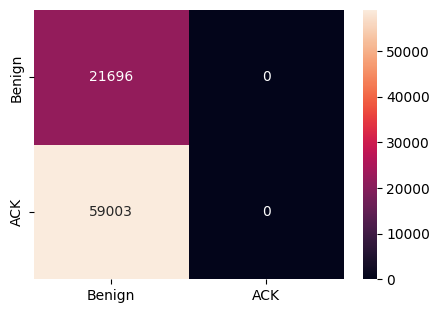





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.009     0.011
 1  ACK           1    1     1  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.013     0.015
 2  ACK           1    1     2  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.009     0.012
 3  ACK           1    1     3  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.004     0.013
 4  ACK           1    1     4  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.012     0.011
 5  ACK           1    1     5  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.005     0.005
 6  ACK           1    1     6  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.004     0.004
 7  ACK           1    1

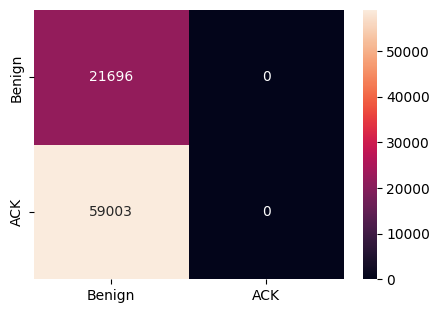





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.758     0.071
 1  ACK           1    1     1  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.838     0.082
 2  ACK           1    1     2  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.825     0.079
 3  ACK           1    1     3  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.763     0.079
 4  ACK           1    1     4  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.825     0.078
 5  ACK           1    1     5  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.838     0.089
 6  ACK           1    1     6  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.709     0.094
 7  ACK           1    1

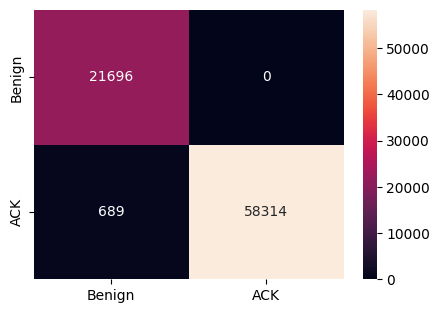





UDP
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.452     0.135
 1  UDP           1    1     1  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.356     0.151
 2  UDP           1    1     2  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.506     0.15
 3  UDP           1    1     3  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.

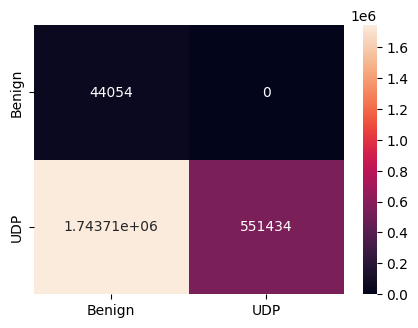





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  DT    0.994    0.949   0.9    0.949  0.923  0.847  0.949    0.067     0.35
 1  UDP           1    1     1  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.029     0.204
 2  UDP           1    1     2  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.016     0.314
 3  UDP           1    1     3  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.016     0.282
 4  UDP           1    1     4  DT    0.883    0.832   0.555  0.832  0.569  0.173  0.832    0.047     0.346
 5  UDP           1    1     5  DT    0.883    0.832   0.555  0.832  0.569  0.173  0.832    0.031     0.298
 6  UDP           1    1     6  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.019     0.299
 7  UDP           1    1 

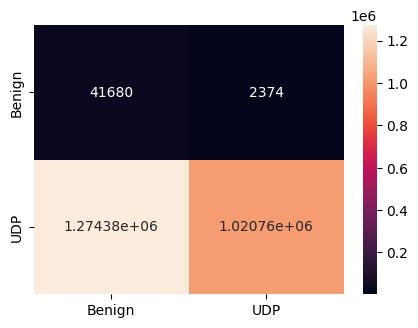





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.441     7.453
 1  UDP           1    1     1  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.456     6.952
 2  UDP           1    1     2  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.424     7.156
 3  UDP           1    1     3  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.424     7.471
 4  UDP           1    1     4  RF    0.894    0.946   0.575  0.946  0.602  0.236  0.946    0.457     6.811
 5  UDP           1    1     5  RF    0.897    0.947   0.577  0.947  0.606  0.243  0.947    0.471     6.606
 6  UDP           1    1     6  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.331     7.029
 7  UDP           1    1

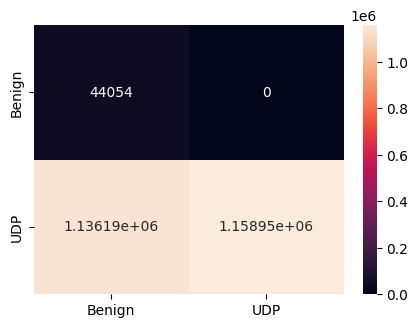





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.041   872.214
 1  UDP           1    1     1  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.063   897.308
 2  UDP           1    1     2  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.049   889.432
 3  UDP           1    1     3  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.063   875.621
 4  UDP           1    1     4  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.049   899.355
 5  UDP           1    1     5  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.063   888.705
 6  UDP           1    1     6  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.048  1004.54
 7  UDP           1    1 

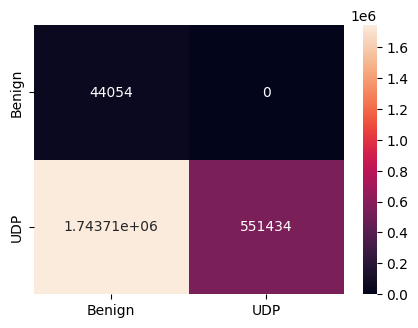





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     2.011
 1  UDP           1    1     1  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.888
 2  UDP           1    1     2  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.791
 3  UDP           1    1     3  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.965
 4  UDP           1    1     4  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.948
 5  UDP           1    1     5  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.015     1.871
 6  UDP           1    1     6  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.729
 7  UDP           1    1

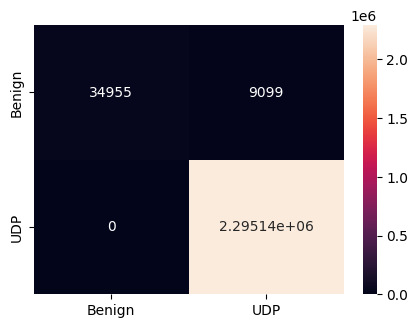





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62    7.624     4.042
 1  UDP           1    1     1  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62    7.737     4.186
 2  UDP           1    1     2  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62    8.205     4.327
 3  UDP           1    1     3  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   10.701     4.721
 4  UDP           1    1     4  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   15.616     4.5
 5  UDP           1    1     5  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   22.728     4.861
 6  UDP           1    1     6  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   19.657     4.673
 7  UDP           1    1  

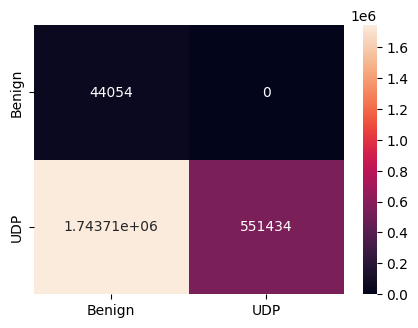





ARP
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'TCP_SYN_R', 'Label']
  

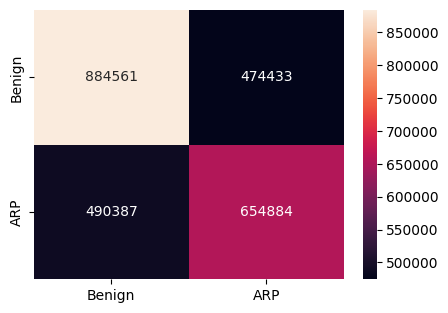





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  DT    0.525    0.508   0.509  0.508  0.495   0.016  0.508    0.644     0.944
 1  ARP           1    1     1  DT    0.532    0.51    0.514  0.51   0.486   0.022  0.51     0.655     1.257
 2  ARP           1    1     2  DT    0.506    0.467   0.263  0.467  0.336  -0.072  0.467    0.708     1.259
 3  ARP           1    1     3  DT    0.531    0.519   0.52   0.519  0.514   0.038  0.519    0.644     1.052
 4  ARP           1    1     4  DT    0.468    0.431   0.253  0.431  0.319  -0.147  0.431    0.755     1.117
 5  ARP           1    1     5  DT    0.532    0.545   0.548  0.545  0.527   0.086  0.545    0.721     1.193
 6  ARP           1    1     6  DT    0.537    0.495   0.27   0.495  0.349  -0.011  0.495    0.708     1.163
 7  ARP        

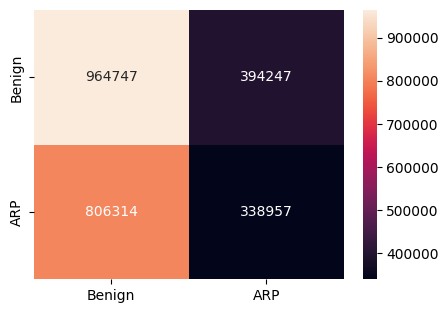





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  RF    0.527    0.486   0.268  0.486  0.345  -0.031  0.486   18.502    46.397
 1  ARP           1    1     1  RF    0.525    0.484   0.267  0.484  0.344  -0.034  0.484   18.653    45.901
 2  ARP           1    1     2  RF    0.526    0.485   0.268  0.485  0.345  -0.032  0.485   18.642    44.772
 3  ARP           1    1     3  RF    0.525    0.483   0.267  0.483  0.344  -0.036  0.483   18.96     45.463
 4  ARP           1    1     4  RF    0.525    0.484   0.267  0.484  0.344  -0.035  0.484   19.084    47.335
 5  ARP           1    1     5  RF    0.53     0.488   0.268  0.488  0.346  -0.026  0.488   19        46.504
 6  ARP           1    1     6  RF    0.528    0.487   0.268  0.487  0.346  -0.029  0.487   20.296    46.656
 7  ARP        

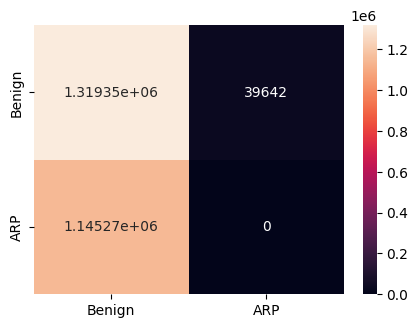





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.298    97.494
 1  ARP           1    1     1  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.315    99.601
 2  ARP           1    1     2  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.298    97.866
 3  ARP           1    1     3  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.315    97.162
 4  ARP           1    1     4  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.315    99.186
 5  ARP           1    1     5  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.298    99.031
 6  ARP           1    1     6  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.299    97.583
 7  ARP        

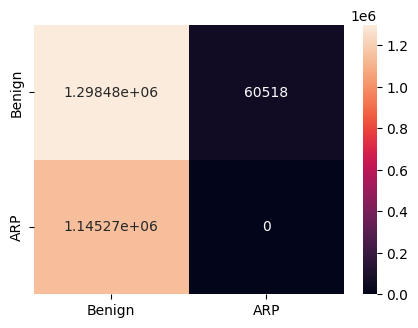





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.032     4.693
 1  ARP           1    1     1  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.023     4.883
 2  ARP           1    1     2  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.023     4.636
 3  ARP           1    1     3  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.032     5.222
 4  ARP           1    1     4  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.032     4.337
 5  ARP           1    1     5  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.016     4.395
 6  ARP           1    1     6  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.031     5.327
 7  ARP        

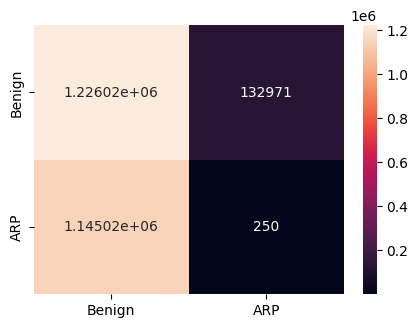





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.953     4.815
 1  ARP           1    1     1  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.849     4.923
 2  ARP           1    1     2  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.768     4.777
 3  ARP           1    1     3  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.938     4.813
 4  ARP           1    1     4  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.919     4.861
 5  ARP           1    1     5  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.927     4.801
 6  ARP           1    1     6  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.928     4.831
 7  ARP        

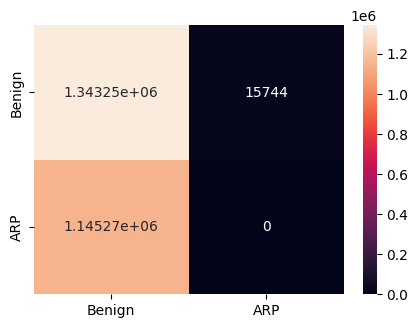





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 1  SP            1    1     1  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 2  SP            1    1     2  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 3  SP            1    1     3  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 4  SP            1    1     4  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.079         0
 5  SP            1    1     5  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063   

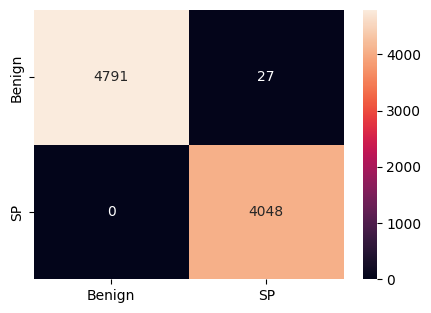





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  DT    0.863    0.873   0.884  0.873  0.862  0.729  0.873    0.009     0.001
 1  SP            1    1     1  DT    0.863    0.873   0.884  0.873  0.862  0.729  0.873    0.016     0
 2  SP            1    1     2  DT    0.995    0.995   0.994  0.995  0.995  0.989  0.995    0.019     0
 3  SP            1    1     3  DT    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0.016     0
 4  SP            1    1     4  DT    0.994    0.995   0.994  0.995  0.994  0.989  0.995    0.016     0
 5  SP            1    1     5  DT    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0         0
 6  SP            1    1     6  DT    0.82     0.803   0.872  0.803  0.806  0.625  0.803    0.016     0
 7  SP            1    1     7  DT    0.863    0

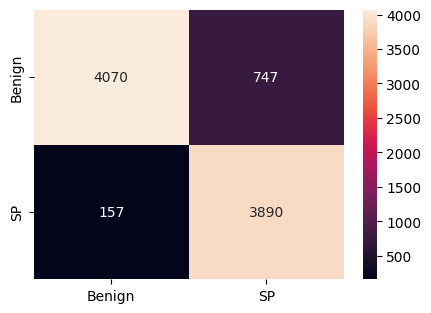





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  RF    0.863    0.874   0.885  0.874  0.863  0.73   0.874    0.016     0
 1  SP            1    1     1  RF    0.862    0.873   0.884  0.873  0.862  0.729  0.873    0.016     0
 2  SP            1    1     2  RF    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0.016     0
 3  SP            1    1     3  RF    0.863    0.873   0.884  0.873  0.862  0.729  0.873    0         0.016
 4  SP            1    1     4  RF    0.863    0.874   0.885  0.874  0.863  0.73   0.874    0.003     0.014
 5  SP            1    1     5  RF    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0         0
 6  SP            1    1     6  RF    0.862    0.873   0.884  0.873  0.862  0.729  0.873    0.013     0.003
 7  SP            1    1     7  RF    0.

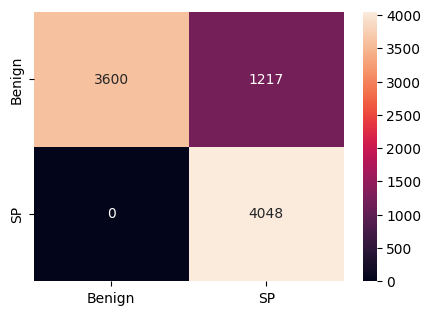





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.031     0.048
 1  SP            1    1     1  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.032
 2  SP            1    1     2  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.047
 3  SP            1    1     3  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.047
 4  SP            1    1     4  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.031     0.04
 5  SP            1    1     5  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.047
 6  SP            1    1     6  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.025     0.038
 7  SP            1    1 

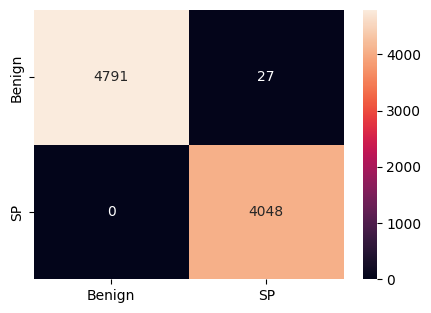





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 1  SP            1    1     1  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 2  SP            1    1     2  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 3  SP            1    1     3  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 4  SP            1    1     4  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 5  SP            1    1     5  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 6  SP            1    1     6  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0.016
 7  SP            1    1     7  NB    0.972    0

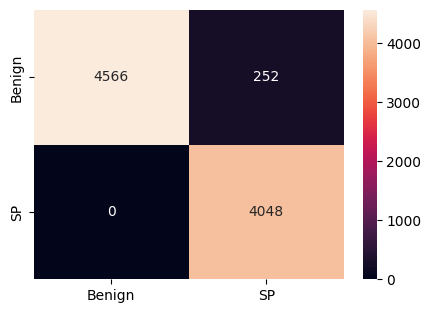





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.464     0.016
 1  SP            1    1     1  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.433     0.016
 2  SP            1    1     2  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.448     0.016
 3  SP            1    1     3  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.464     0.016
 4  SP            1    1     4  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.431     0.016
 5  SP            1    1     5  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.433     0.016
 6  SP            1    1     6  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.369     0.016
 7  SP            1    1

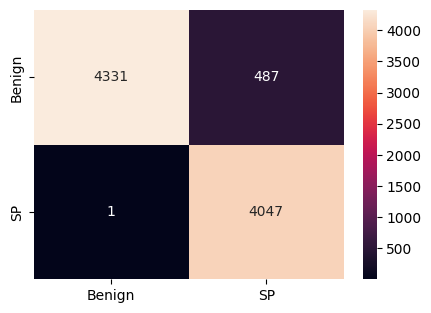





BF
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  LR    0.503    0.543   0.739  0.543  0.403  0.079  0.543    0.348         0
 1  BF            1    1     1  LR    0.506    0.546   0.74   0.546  0.409  0.085  0.546    0.267         0
 2  BF            1    1     2  LR    0.501    0.542   0.739 

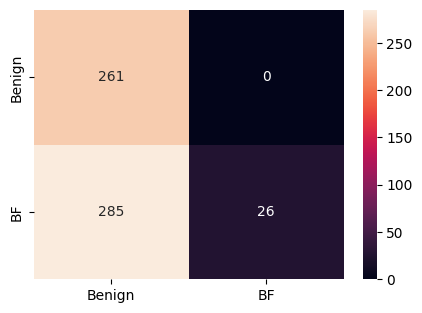





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.037         0
 1  BF            1    1     1  DT    0.551    0.588   0.752  0.588  0.485  0.163  0.588    0.047         0
 2  BF            1    1     2  DT    0.455    0.5     0.228  0.5    0.313  0      0.5      0.047         0
 3  BF            1    1     3  DT    0.464    0.508   0.73   0.508  0.331  0.015  0.508    0.043         0
 4  BF            1    1     4  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.047         0
 5  BF            1    1     5  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.031         0
 6  BF            1    1     6  DT    0.455    0.5     0.228  0.5    0.313  0      0.5      0.047         0
 7  BF            1    1

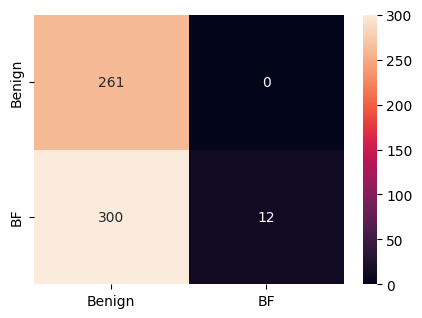





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.299     0.031
 1  BF            1    1     1  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.297     0.016
 2  BF            1    1     2  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.335     0.016
 3  BF            1    1     3  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.219     0.031
 4  BF            1    1     4  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.234     0.032
 5  BF            1    1     5  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.156     0.021
 6  BF            1    1     6  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.219     0.031
 7  BF            1    1

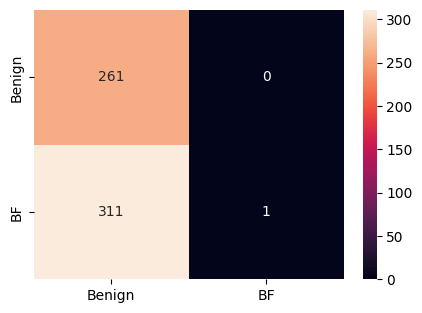





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  BF            1    1     0  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.043
 1  BF            1    1     1  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.026
 2  BF            1    1     2  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.039
 3  BF            1    1     3  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.031
 4  BF            1    1     4  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.047
 5  BF            1    1     5  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.063
 6  BF            1    1     6  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0.016     0.031
 7  BF            1    1     7  K

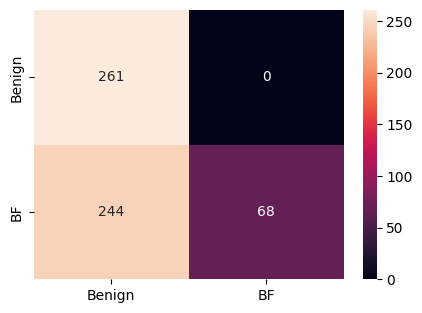





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.006     0.001
 1  BF            1    1     1  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.008     0
 2  BF            1    1     2  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0         0
 3  BF            1    1     3  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0         0
 4  BF            1    1     4  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.016     0
 5  BF            1    1     5  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.009     0
 6  BF            1    1     6  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0         0
 7  BF            1    1     7  NB    0.745    0

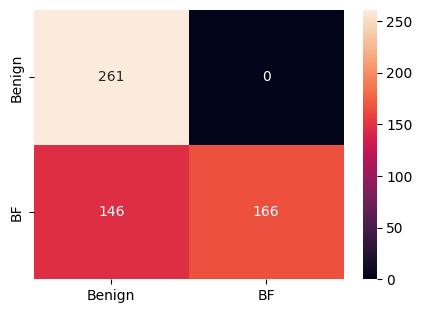





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.207     0.005
 1  BF            1    1     1  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.152     0
 2  BF            1    1     2  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.072     0.016
 3  BF            1    1     3  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.026     0
 4  BF            1    1     4  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.087     0
 5  BF            1    1     5  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.173     0.016
 6  BF            1    1     6  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    4.532     0.014
 7  BF            1    1     7  XGB 

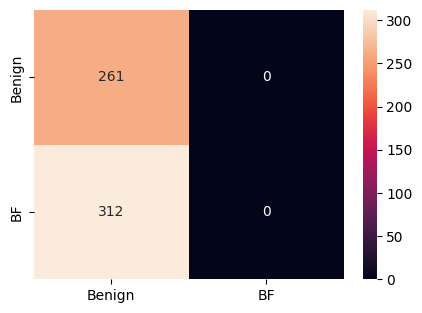





OS
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap   

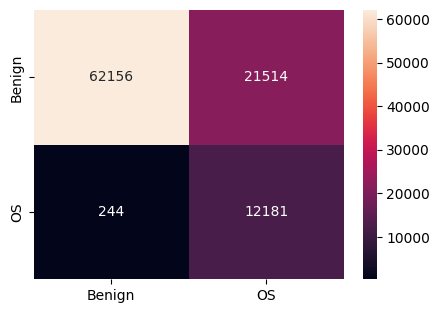





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.073     0.027
 1  OS            1    1     1  DT    0.61     0.758   0.616  0.758  0.551  0.23   0.758    0.099     0.032
 2  OS            1    1     2  DT    0.61     0.758   0.616  0.758  0.551  0.23   0.758    0.09      0.03
 3  OS            1    1     3  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.08      0.04
 4  OS            1    1     4  DT    0.61     0.758   0.616  0.758  0.551  0.23   0.758    0.098     0.033
 5  OS            1    1     5  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.087     0.03
 6  OS            1    1     6  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.083     0.03
 7  OS            1    1    

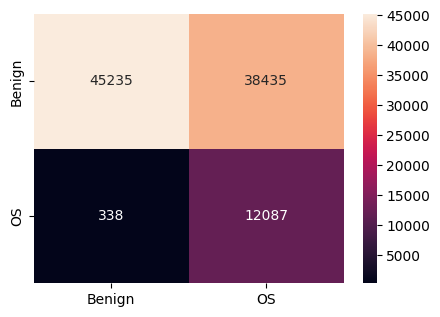





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            1    1     0  RF    0.883    0.589   0.778  0.589  0.617   0.254  0.589    0.025     0.063
 1  OS            1    1     1  RF    0.877    0.589   0.731  0.589  0.614   0.245  0.589    0.04      0.1
 2  OS            1    1     2  RF    0.638    0.435   0.463  0.435  0.438  -0.088  0.435    0.038     0.054
 3  OS            1    1     3  RF    0.611    0.758   0.616  0.758  0.552   0.23   0.758    0.033     0.064
 4  OS            1    1     4  RF    0.944    0.93    0.856  0.93   0.887   0.775  0.93     0.03      0.065
 5  OS            1    1     5  RF    0.881    0.588   0.764  0.588  0.615   0.25   0.588    0.024     0.058
 6  OS            1    1     6  RF    0.894    0.612   0.855  0.612  0.651   0.322  0.612    0.038     0.06
 7  OS            

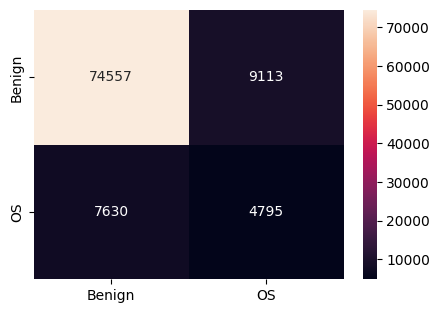





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            1    1     0  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0         8.257
 1  OS            1    1     1  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.006     8.054
 2  OS            1    1     2  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.009     7.694
 3  OS            1    1     3  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.011     7.609
 4  OS            1    1     4  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.01      7.762
 5  OS            1    1     5  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.005     7.646
 6  OS            1    1     6  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.01      7.39
 7  OS          

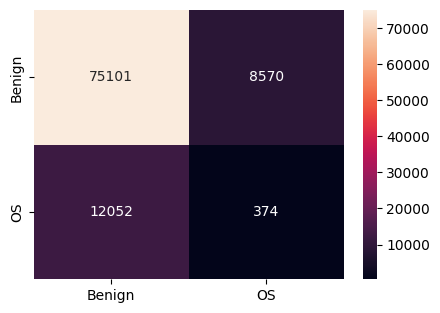





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.017     0.188
 1  OS            1    1     1  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.015     0.175
 2  OS            1    1     2  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.02      0.168
 3  OS            1    1     3  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.012     0.188
 4  OS            1    1     4  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.017     0.169
 5  OS            1    1     5  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.02      0.186
 6  OS            1    1     6  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.019     0.174
 7  OS            1    1

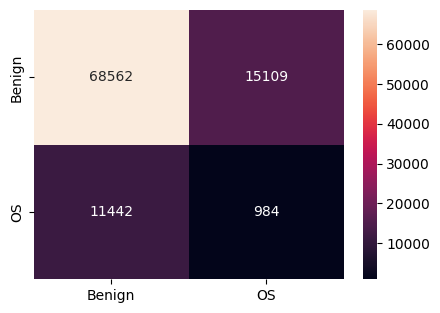





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.08      0.224
 1  OS            1    1     1  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.122     0.253
 2  OS            1    1     2  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.05      0.249
 3  OS            1    1     3  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.04      0.27
 4  OS            1    1     4  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.022     0.277
 5  OS            1    1     5  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.026     0.244
 6  OS            1    1     6  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.002     0.287
 7  OS            1    1 

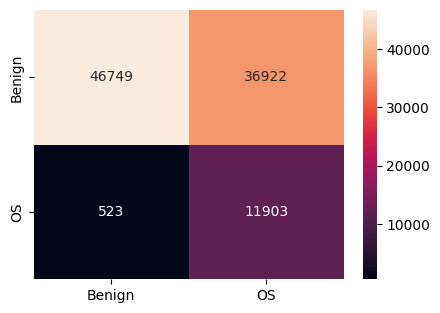





SCHD
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  LR    0.989    0.971   0.583  0.971  0.639  0.281  0.971    0.34      0.011
 1  SCHD          1    1     1  LR    0.989    0.971   0.583  0.971  0.639  0.281  0.971    0.283     0.01
 2  SCHD          1    1     2  LR    0.989    0

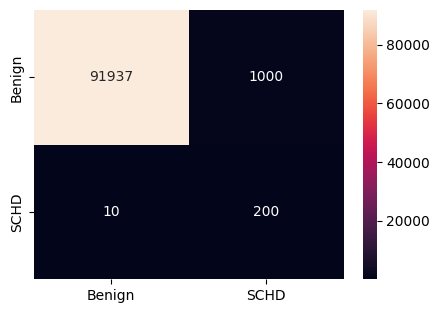





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  DT    0.998    0.619   0.902  0.619  0.683  0.367  0.619    0.051     0.025
 1  SCHD          1    1     1  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.06      0.02
 2  SCHD          1    1     2  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.05      0.025
 3  SCHD          1    1     3  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.06      0.02
 4  SCHD          1    1     4  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.07      0.021
 5  SCHD          1    1     5  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.053     0.025
 6  SCHD          1    1     6  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.058     0.017
 7  SCHD          1    1  

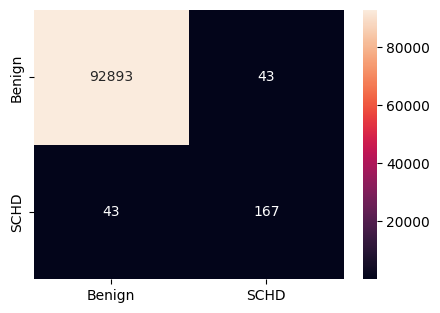





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  RF    0.998    0.616   0.778  0.616  0.664  0.328  0.616    1.172     0.523
 1  SCHD          1    1     1  RF    0.998    0.614   0.886  0.614  0.676  0.352  0.614    1.111     0.527
 2  SCHD          1    1     2  RF    0.998    0.612   0.943  0.612  0.678  0.357  0.612    1.133     0.508
 3  SCHD          1    1     3  RF    0.998    0.614   0.823  0.614  0.669  0.337  0.614    1.142     0.502
 4  SCHD          1    1     4  RF    0.998    0.617   0.907  0.617  0.681  0.362  0.617    1.186     0.566
 5  SCHD          1    1     5  RF    0.998    0.707   0.884  0.707  0.769  0.538  0.707    1.122     0.556
 6  SCHD          1    1     6  RF    0.998    0.614   0.944  0.614  0.681  0.363  0.614    1.13      0.549
 7  SCHD          1    1

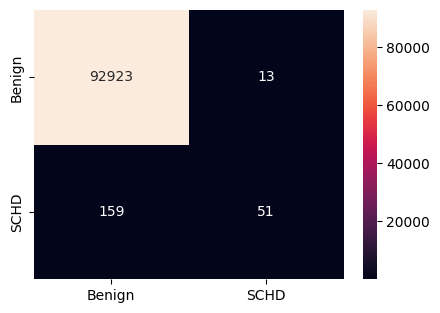





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.078     1.885
 1  SCHD          1    1     1  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.078     1.854
 2  SCHD          1    1     2  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.08      1.914
 3  SCHD          1    1     3  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.077     1.906
 4  SCHD          1    1     4  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.073     1.889
 5  SCHD          1    1     5  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.072     1.964
 6  SCHD          1    1     6  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.078     1.913
 7  SCHD          1    1

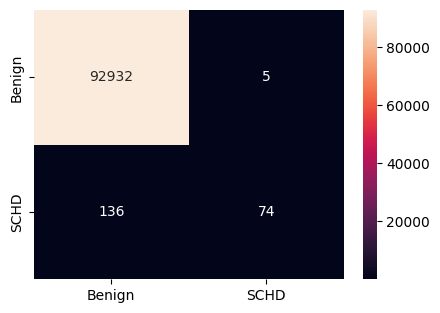





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.008     0.117
 1  SCHD          1    1     1  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.01      0.116
 2  SCHD          1    1     2  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.016     0.109
 3  SCHD          1    1     3  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.013     0.1
 4  SCHD          1    1     4  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.008     0.121
 5  SCHD          1    1     5  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.008     0.135
 6  SCHD          1    1     6  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.009     0.108
 7  SCHD          1    1  

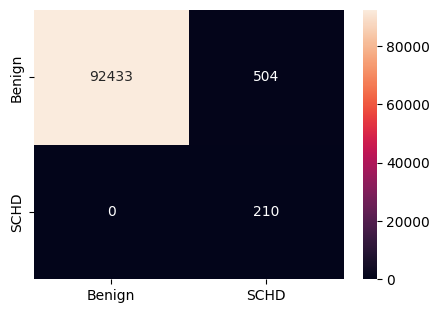





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    1.007     0.192
 1  SCHD          1    1     1  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.898     0.194
 2  SCHD          1    1     2  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.971     0.194
 3  SCHD          1    1     3  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.96      0.17
 4  SCHD          1    1     4  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.888     0.184
 5  SCHD          1    1     5  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    1.04      0.178
 6  SCHD          1    1     6  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    1.082     0.161
 7  SCHD          1    1 

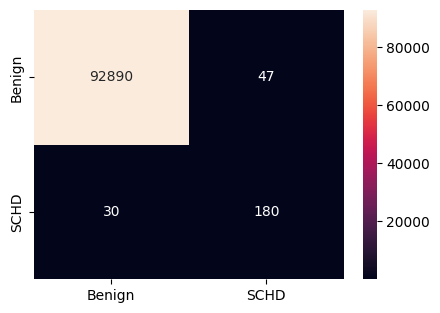





MHDis
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  LR        1        1   0.997      1  0.998  0.997      1    0.188     0
 1  MHDis         1    1     1  LR        1        1   0.997      1  0.998  0.997      1    0.346     0.005
 2  MHDis         1    1     2  LR        1        1   0.997      1  0.998  0.997      1    0.158     0
 3  MHDis         1    1     3  LR        1        1   0.997      1  0.998  0.997      1    0.263     0
 4  MHDis         1    1     4  LR        1        1   0.997  

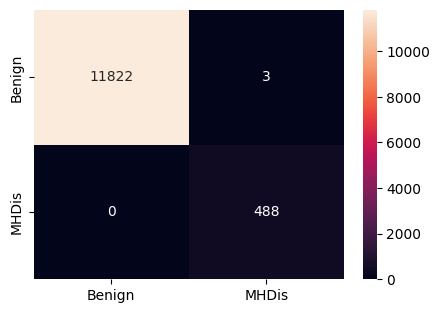





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  DT    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.022     0
 1  MHDis         1    1     1  DT    0.964    0.55    0.972  0.55   0.582  0.176  0.55     0.017     0.008
 2  MHDis         1    1     2  DT    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.017     0.005
 3  MHDis         1    1     3  DT    0.964    0.55    0.972  0.55   0.582  0.176  0.55     0.019     0.005
 4  MHDis         1    1     4  DT    0.97     0.623   0.981  0.623  0.689  0.384  0.623    0.015     0.008
 5  MHDis         1    1     5  DT    0.964    0.55    0.972  0.55   0.582  0.176  0.55     0.019     0
 6  MHDis         1    1     6  DT    0.998    0.977   0.998  0.977  0.987  0.975  0.977    0.017     0
 7  MHDis         1    1     7  DT  

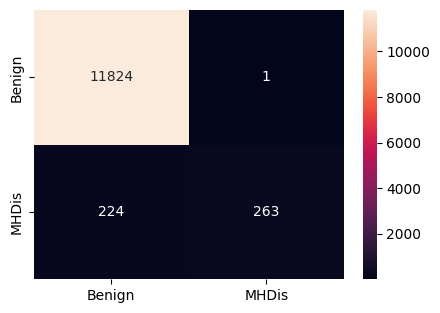





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.485     0.075
 1  MHDis         1    1     1  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.465     0.073
 2  MHDis         1    1     2  RF    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.467     0.07
 3  MHDis         1    1     3  RF    0.998    0.975   0.998  0.975  0.986  0.973  0.975    0.47      0.07
 4  MHDis         1    1     4  RF    0.996    0.953   0.997  0.953  0.974  0.948  0.953    0.489     0.07
 5  MHDis         1    1     5  RF    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.482     0.08
 6  MHDis         1    1     6  RF    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.5       0.07
 7  MHDis         1    1     

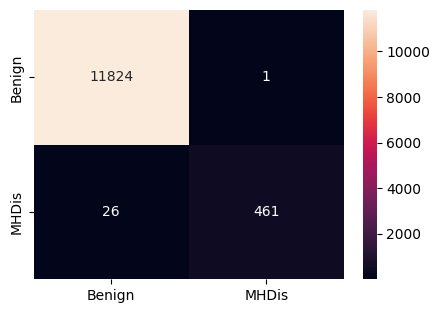





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.02      0.47
 1  MHDis         1    1     1  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.02      0.432
 2  MHDis         1    1     2  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.027     0.488
 3  MHDis         1    1     3  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.017     0.5
 4  MHDis         1    1     4  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.027     0.49
 5  MHDis         1    1     5  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.028     0.472
 6  MHDis         1    1     6  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.03      0.453
 7  MHDis         1    1    

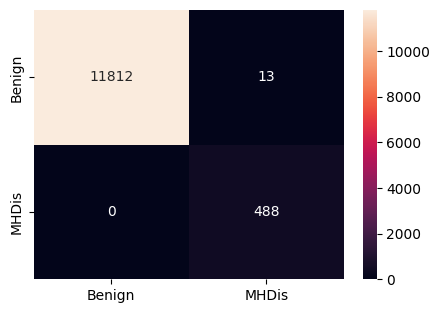





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.008     0.008
 1  MHDis         1    1     1  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.007     0.008
 2  MHDis         1    1     2  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.004     0.013
 3  MHDis         1    1     3  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.008     0.008
 4  MHDis         1    1     4  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.003     0.008
 5  MHDis         1    1     5  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.01      0.006
 6  MHDis         1    1     6  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.01      0.01
 7  MHDis         1    1 

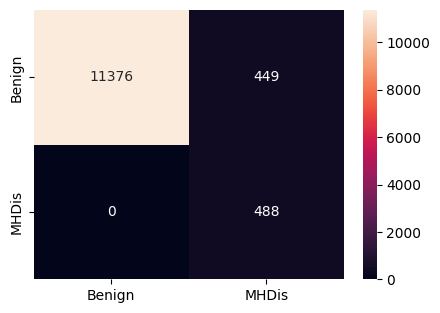





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.637     0.024
 1  MHDis         1    1     1  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.68      0.022
 2  MHDis         1    1     2  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.714     0.083
 3  MHDis         1    1     3  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.588     0.093
 4  MHDis         1    1     4  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.481     0.053
 5  MHDis         1    1     5  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.577     0.087
 6  MHDis         1    1     6  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.891     0.113
 7  MHDis         1    1

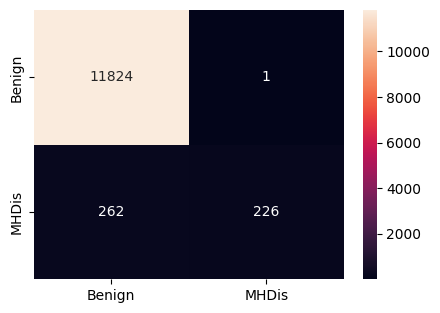

In [ ]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  

In [ ]:
print(2)

2


In [ ]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]
    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

In [ ]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)